In [1]:
from pyxdf import match_streaminfos, resolve_streams
from mnelab.io.xdf import read_raw_xdf
import mne
import mnelab
from mne.time_frequency import csd_morlet, csd_fourier
from mne.time_frequency import tfr_morlet
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_test
import os.path
import pandas as pd
import matplotlib.patches as patches

In [2]:
import scipy; print(scipy.__version__)

path ='./pilot/'
# ['TP9', 'AF7', 'AF8', 'TP10']
picks = ['AF7', 'AF8']
numOfPilots = 20
reject_criteria = dict(eeg=100e-6)   
isResultMat = False
numParticipants = 0


1.11.1


In [3]:
mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

In [4]:
for pnum in range(1,numOfPilots +1):
    paraticipant = "P"+ str(pnum)
    print(pnum)

    path ='./'+ paraticipant +'/'
    raw = None 
    for num in range(1,5):
        fileNamei = paraticipant +'_b'  + str(num) + ".xdf"
        path_addr = path + fileNamei
        if (os.path.exists(path_addr)):
            streams = resolve_streams(path_addr)
            stream_id = match_streaminfos(streams, [{"type": "EEG"}])[0]
            rawi = read_raw_xdf(path_addr, stream_ids=[stream_id]).resample(250)
            
            if (raw is not None):
                mne.io.concatenate_raws([raw, rawi], on_mismatch="ignore")
            else:
                raw = rawi    
    if (raw is not None):
        raw.filter(2, 45)
        raw2 =raw.copy().resample(250)
        ica = mne.preprocessing.ICA(n_components = 4, random_state = 0)
        ica.fit(raw2)
        raw2 = ica.apply(raw2,exclude = [0])
        events, _ = mne.events_from_annotations(raw2)

        event_ids_congruent = {"Non distraction + congruent":6 ,"distraction + congruent" :4 }
        event_ids_incongruent = {"Non distraction + incongruent":7,"distraction + incongruent" :5 }

        epoch_congruent_ND = mne.Epochs(raw2, events,event_id = event_ids_congruent["Non distraction + congruent"],  reject=reject_criteria, preload=True,tmin = -0.3, tmax=1 , baseline=(-0.3, 0))
        epoch_congruent_D = mne.Epochs(raw2, events,event_id = event_ids_congruent["distraction + congruent"], reject=reject_criteria,  preload=True,tmin = -0.3, tmax=1, baseline=(-0.3, 0))

        # epoch_incongruent_ND = epoch_incongruent_ND.resample(250)
        # epoch_incongruent_D = epoch_incongruent_D.resample(250)
        epoch_congruent_ND.pick_channels(picks)
        epoch_congruent_D.pick_channels(picks)

        decim = 2
        freqs = np.arange(2, 20, 2)  # define frequencies of interest
        n_cycles = 1.5

        tfr_epochs_1 = tfr_morlet(epoch_congruent_ND, freqs,
                                n_cycles=n_cycles, decim=decim,
                                return_itc=False, average=False)

        tfr_epochs_2 = tfr_morlet(epoch_congruent_D, freqs,
                                n_cycles=n_cycles, decim=decim,
                                return_itc=False, average=False)

        tfr_epochs_1.apply_baseline(mode='ratio', baseline=(None, 0))
        tfr_epochs_2.apply_baseline(mode='ratio', baseline=(None, 0))

        numfreqs= tfr_epochs_2.freqs.shape[0]
        numtimes= tfr_epochs_2.times.shape[0]

        print(tfr_epochs_1.times.shape[0])
        print(tfr_epochs_2.times.shape[0])

        tfr_times = tfr_epochs_2.times
        tfr_freqs = tfr_epochs_2.freqs

# change this in every run
        if(isResultMat == False):
            resultMat = np.zeros((numOfPilots,2,numfreqs,numtimes))
            isResultMat = True


        epochs_power_1 = tfr_epochs_1.data[:, :, :, :]  # only 1 channel as 3D matrix
        epochs_power_2 = tfr_epochs_2.data[:, :, :, :] # only 1 channel as 3D matrix

        print(epochs_power_1.data.shape) # (12, 2, 96, 163)
        print(epochs_power_2.data.shape) # (12, 2, 96, 163)

       
        epochs_power_1_avg = np.mean(epochs_power_1, axis =1)  # only 1 channel as 3D matrix
        epochs_power_2_avg = np.mean(epochs_power_2, axis =1)  # only 1 channel as 3D matrix

        print(epochs_power_1_avg.data.shape) # (12, 96, 163)
        print(epochs_power_2_avg.data.shape) # (12, 96, 163)

        tfr_nd = np.mean(epochs_power_1_avg, axis=0)
        tfr_d = np.mean(epochs_power_2_avg, axis=0)

        print(tfr_nd.data.shape) # (96, 163)
        print(tfr_d.data.shape) #  (96, 163)


        resultMat[numParticipants,0,:,:] = tfr_nd
        resultMat[numParticipants,1,:,:] = tfr_d
        numParticipants = numParticipants + 1

   

Stream 2: Calculated effective sampling rate 473.7025 Hz is different from specified rate 256.0000 Hz.


1


Stream 2: Calculated effective sampling rate 455.8237 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 475.2557 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 459.6645 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 476.0124 Hz is different from specified rate 256.0000 Hz.


163
163
(48, 2, 9, 163)
(48, 2, 9, 163)
(48, 9, 163)
(48, 9, 163)
(9, 163)
(9, 163)
2


Stream 2: Calculated effective sampling rate 390.8616 Hz is different from specified rate 256.0000 Hz.
C:\Users\erangad\AppData\Local\Temp\ipykernel_22484\533547958.py:16: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  mne.io.concatenate_raws([raw, rawi], on_mismatch="ignore")
Stream 2: Calculated effective sampling rate 454.4369 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 464.3009 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 467.3554 Hz is different from specified rate 256.0000 Hz.


163
163
(43, 2, 9, 163)
(42, 2, 9, 163)
(43, 9, 163)
(42, 9, 163)
(9, 163)
(9, 163)
3


Stream 2: Calculated effective sampling rate 466.8037 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 461.8854 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 463.4191 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 488.5306 Hz is different from specified rate 256.0000 Hz.


163
163
(44, 2, 9, 163)
(43, 2, 9, 163)
(44, 9, 163)
(43, 9, 163)
(9, 163)
(9, 163)
4


Stream 2: Calculated effective sampling rate 473.6132 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 459.0440 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 457.9969 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 452.6263 Hz is different from specified rate 256.0000 Hz.


163
163
(48, 2, 9, 163)
(48, 2, 9, 163)
(48, 9, 163)
(48, 9, 163)
(9, 163)
(9, 163)
5


Stream 2: Calculated effective sampling rate 461.1234 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 470.4595 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 484.6633 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 469.7706 Hz is different from specified rate 256.0000 Hz.


163
163
(45, 2, 9, 163)
(48, 2, 9, 163)
(45, 9, 163)
(48, 9, 163)
(9, 163)
(9, 163)
6


Stream 2: Calculated effective sampling rate 479.3669 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 454.1174 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 461.5314 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 480.7917 Hz is different from specified rate 256.0000 Hz.


163
163
(45, 2, 9, 163)
(44, 2, 9, 163)
(45, 9, 163)
(44, 9, 163)
(9, 163)
(9, 163)
7


Stream 2: Calculated effective sampling rate 473.8533 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 454.6949 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 444.6427 Hz is different from specified rate 256.0000 Hz.


163
163
(41, 2, 9, 163)
(24, 2, 9, 163)
(41, 9, 163)
(24, 9, 163)
(9, 163)
(9, 163)
8


Stream 2: Calculated effective sampling rate 479.8115 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 479.8235 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 461.6930 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 454.5493 Hz is different from specified rate 256.0000 Hz.


163
163
(43, 2, 9, 163)
(48, 2, 9, 163)
(43, 9, 163)
(48, 9, 163)
(9, 163)
(9, 163)
9


Stream 2: Calculated effective sampling rate 474.2825 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 484.0926 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 467.5936 Hz is different from specified rate 256.0000 Hz.
C:\Users\erangad\AppData\Local\Temp\ipykernel_22484\533547958.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  mne.io.concatenate_raws([raw, rawi], on_mismatch="ignore")
Stream 2: Calculated effective sampling rate 397.6749 Hz is different from specified rate 256.0000 Hz.


163
163
(45, 2, 9, 163)
(46, 2, 9, 163)
(45, 9, 163)
(46, 9, 163)
(9, 163)
(9, 163)
10


Stream 2: Calculated effective sampling rate 326.8358 Hz is different from specified rate 256.0000 Hz.
C:\Users\erangad\AppData\Local\Temp\ipykernel_22484\533547958.py:16: RuntimeWarning: Omitted 13 annotation(s) that were outside data range.
  mne.io.concatenate_raws([raw, rawi], on_mismatch="ignore")
Stream 2: Calculated effective sampling rate 479.4622 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 453.6855 Hz is different from specified rate 256.0000 Hz.
Stream 2: Calculated effective sampling rate 482.1637 Hz is different from specified rate 256.0000 Hz.


163
163
(48, 2, 9, 163)
(44, 2, 9, 163)
(48, 9, 163)
(44, 9, 163)
(9, 163)
(9, 163)
11


Stream 2: Calculated effective sampling rate 484.7892 Hz is different from specified rate 256.0000 Hz.


KeyboardInterrupt: 

In [13]:
# for num in range(nums):
#     file_addr = path +"P"+ str(num +1) + "/" + test 
#     print(path +"P"+ str(num +1) + "/" + test)
#     print(os.path.exists(file_addr))
#     if (os.path.exists(file_addr)):
#         streams = resolve_streams(file_addr)
#         stream_id = match_streaminfos(streams, [{"type": "EEG"}])[0]
#         raw = read_raw_xdf(file_addr, stream_ids=[stream_id])
#         raw.filter(0.5, 45)
#         raw2 =raw.copy().resample(250)
#         ica = mne.preprocessing.ICA(n_components = 4, random_state = 0)
#         ica.fit(raw2)
#         raw2 = ica.apply(raw2,exclude = [0])
#         events, _ = mne.events_from_annotations(raw2)
#         event_ids_congruent = {"Non distraction + congruent":6,"distraction + congruent" :4 }

#         epoch_incongruent_ND = mne.Epochs(raw2, events,event_id = event_ids_congruent["Non distraction + congruent"],  preload=True,tmin = -0.5, tmax=0.8 , baseline=(None, 0))
#         epoch_incongruent_D = mne.Epochs(raw2, events,event_id = event_ids_congruent["distraction + congruent"],  preload=True,tmin = -0.5, tmax=0.8, baseline=(None, 0))

#         # epoch_incongruent_ND = epoch_incongruent_ND.resample(250)
#         # epoch_incongruent_D = epoch_incongruent_D.resample(250)
#         epoch_incongruent_ND.pick_channels([chan])
#         epoch_incongruent_D.pick_channels([chan])

#         decim = 2
#         freqs = np.arange(2, 45, 0.5)  # define frequencies of interest
#         n_cycles = 1.5

#         tfr_epochs_1 = tfr_morlet(epoch_incongruent_ND, freqs,
#                                 n_cycles=n_cycles, decim=decim,
#                                 return_itc=False, average=False)

#         tfr_epochs_2 = tfr_morlet(epoch_incongruent_D, freqs,
#                                 n_cycles=n_cycles, decim=decim,
#                                 return_itc=False, average=False)

#         tfr_epochs_1.apply_baseline(mode='ratio', baseline=(None, 0))
#         tfr_epochs_2.apply_baseline(mode='ratio', baseline=(None, 0))

#         numfreqs= tfr_epochs_2.freqs.shape[0]
#         numtimes= tfr_epochs_2.times.shape[0]

#         print(tfr_epochs_1.times.shape[0])
#         print(tfr_epochs_2.times.shape[0])

#         tfr_times = tfr_epochs_2.times
#         tfr_freqs = tfr_epochs_2.freqs

# # change this in every run
#         if(isResultMat == False):
#             resultMat = np.zeros((numOfPilots,2,numfreqs,numtimes))
#             isResultMat = True


#         epochs_power_1 = tfr_epochs_1.data[:, 0, :, :]  # only 1 channel as 3D matrix
#         epochs_power_2 = tfr_epochs_2.data[:, 0, :, :]  # only 1 channel as 3D matrix

#         print(epochs_power_1.data.shape) # (12, 96, 163)
#         print(epochs_power_2.data.shape) # (12, 96, 163)

#         tfr_nd = np.mean(epochs_power_1, axis=0)
#         tfr_d = np.mean(epochs_power_2, axis=0)

#         print(tfr_nd.data.shape) # (12, 96, 163)
#         print(tfr_d.data.shape) # (12, 96, 163)


#         resultMat[numParticipants,0,:,:] = tfr_nd
#         resultMat[numParticipants,1,:,:] = tfr_d
#         numParticipants = numParticipants + 1

In [14]:
numParticipants

20

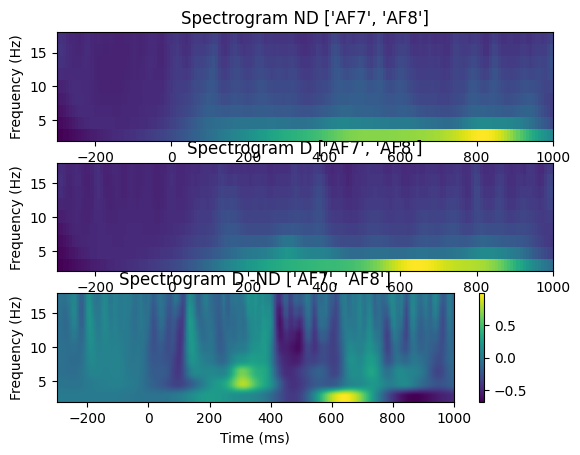

In [15]:
# Pick a time frequency region 
# shape (5, 2, 96, 163)
spectrogram_nd = np.mean(resultMat[:,0,:,:], axis=0)
spectrogram_d =   np.mean(resultMat[:,1,:,:], axis=0)

times = 1e3 * epoch_congruent_ND.times  # change unit to ms


fig, (ax, ax2, ax3) = plt.subplots(3, 1)

ax.imshow(spectrogram_nd,
          extent=[times[0], times[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Spectrogram ND '+  str(picks))

ax2.imshow(spectrogram_d,
          extent=[times[0], times[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower')

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title(f'Spectrogram D ' +  str(picks))


c = ax3.imshow(spectrogram_d - spectrogram_nd,
          extent=[times[0], times[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower')


ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title(f'Spectrogram D -ND ' + str(picks))

plt.colorbar(c)


plt.show()

(9, 163)


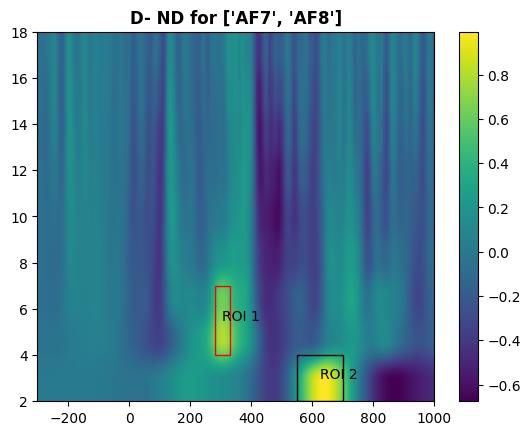

In [42]:
# Pick a time frequency region 
# shape (5, 2, 96, 163)
diff = spectrogram_d - spectrogram_nd

print(diff.shape)

# Create figure and axes
fig, ax = plt.subplots()

c =  ax.imshow(diff, extent=[times[0], times[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower')

time1 = [280, 330]
time2 = [550, 700]

freq1 = [4, 7]
freq2 = [2, 4]

# Create a Rectangle patch
rect1 = patches.Rectangle((time1[0], freq1[0]), (time1[1] - time1[0]), (freq1[1] - freq1[0]), linewidth=1, edgecolor='r', facecolor='none')
# Create a Rectangle patch
rect2 = patches.Rectangle((time2[0], freq2[0]), (time2[1] - time2[0]), (freq2[1] - freq2[0]), linewidth=1, edgecolor='k', facecolor='none')

ax.text((time1[0]+ time1[1])/2, (freq1[0]+ freq1[1])/2, 'ROI 1')
ax.text((time2[0]+ time2[1])/2, (freq2[0]+ freq2[1])/2, 'ROI 2')

ax.add_patch(rect1)
ax.add_patch(rect2)


plt.colorbar(c)


plt.title('D- ND for ' + str(picks),  fontweight ="bold")
plt.show()


In [43]:
# # Pick a time frequency region 
# # shape (5, 2, 96, 163)
# grandAvg = np.mean(resultMat, axis=1)
# grandAvg = np.mean(grandAvg, axis=0)

# print(grandAvg.shape)

# # Create figure and axes
# fig, ax = plt.subplots()

# c =  ax.imshow(grandAvg, extent=[times[0], times[-1], freqs[0], freqs[-1]],
#           aspect='auto', origin='lower')

# time1 = [250, 600]
# time2 = [600, 950]

# freq1 = [0, 4]
# freq2 = [2, 4]

# # Create a Rectangle patch
# rect1 = patches.Rectangle((time1[0], freq1[0]), (time1[1] - time1[0]), (freq1[1] - freq1[0]), linewidth=1, edgecolor='r', facecolor='none')
# # Create a Rectangle patch
# rect2 = patches.Rectangle((time2[0], freq2[0]), (time2[1] - time2[0]), (freq2[1] - freq2[0]), linewidth=1, edgecolor='k', facecolor='none')

# ax.text((time1[0]+ time1[1])/2, (freq1[0]+ freq1[1])/2, 'ROI 1')
# ax.text((time2[0]+ time2[1])/2, (freq2[0]+ freq2[1])/2, 'ROI 2')

# ax.add_patch(rect1)
# ax.add_patch(rect2)


# plt.colorbar(c)


# plt.title('ND + D for ' + str(picks),  fontweight ="bold")
# plt.show()


In [44]:
# get indexes of the interested regions 
def getIndexArrayOfArray ( main_array, value_list, divisor):
    index_list =[]
    for val in value_list:
        idx = np.argmin( np.abs(main_array - (val / divisor)))
        index_list.append(idx)
    return index_list

time1idx = getIndexArrayOfArray(tfr_times, time1, 1e3) 
time2idx = getIndexArrayOfArray(tfr_times, time2, 1e3) 

freq1idx = getIndexArrayOfArray(tfr_freqs, freq1, 1) 
freq2idx = getIndexArrayOfArray(tfr_freqs, freq2, 1) 

print(time2idx)    
    

[106, 125]


In [45]:
resultMat.shape

(20, 2, 9, 163)

In [46]:
labels = [ 'ROI-1 ND','ROI-1 D','ROI-2 ND','ROI-2 D' ];
data = np.zeros((4,numParticipants));

# resultMat shape (5, 2, 96, 163)
# np.mean(resultMat, axis=1)


data[0,:] =  np.mean(np.mean(resultMat[:,0, freq1idx[0]:freq1idx[1], time1idx[0]: time1idx[1]], axis = 2), axis =1)
data[1,:] =  np.mean(np.mean(resultMat[:,1, freq1idx[0]:freq1idx[1], time1idx[0]: time1idx[1]], axis = 2), axis =1)

data[2,:] =  np.mean(np.mean(resultMat[:,0, freq2idx[0]:freq2idx[1], time2idx[0]: time2idx[1]], axis = 2), axis =1)
data[3,:] =  np.mean(np.mean(resultMat[:,1, freq2idx[0]:freq2idx[1], time2idx[0]: time2idx[1]], axis = 2), axis =1)

print(data.shape)

(4, 20)


In [47]:
data.shape[1]

20

In [48]:
for col in range(data.shape[1] -1, -1, -1):
    print(col)


19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


deleted
deleted
deleted


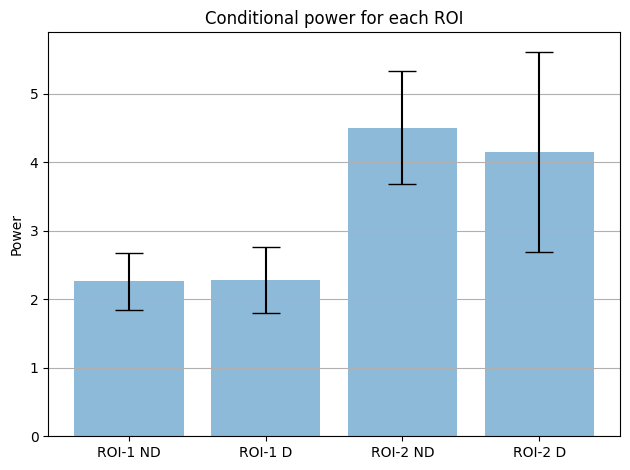

In [49]:
from scipy import stats

d_mean = np.mean(data, axis= 1)
d_std = np.std(data, axis= 1)

x_pos = np.arange(len(labels))

datai = data

for col in range(datai.shape[1] -1, -1, -1):
    variance_per_subjecti =  np.abs(datai[:,col] - d_mean)
    dist_from_2stds =  variance_per_subjecti - 2 * d_std
    # print(dist_from_2stds)
    for val in dist_from_2stds:
        if(val> 0):
            datai = np.delete(datai,(col), axis=1)
            print("deleted")
            break;

d_mean = np.mean(datai, axis= 1)
d_std = np.std(datai, axis= 1) 
n = datai.shape[1]
yerr = d_std / np.sqrt(n) * stats.t.ppf(1-0.05/2, n - 1)       

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, d_mean, yerr=yerr, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Power')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Conditional power for each ROI')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()


In [50]:
d_std

array([0.81428807, 0.92695677, 1.59906317, 2.84324492])

In [51]:
d_mean

array([2.25974238, 2.28219401, 4.50254729, 4.15035336])

In [52]:
np.mean(datai[0,:])


2.2597423784802064

In [53]:
np.mean(datai[1,:])

2.282194014517401

In [54]:
# variance_per_subjecti =  np.abs(np.abs(datai[:,0] - d_mean))

import numpy as np
from scipy import stats

print("T-test for the ROI 1")
result_roi_1 = stats.ttest_ind(datai[0,:], datai[1,:])
print("P - Val : "+ str(result_roi_1.pvalue))


print("T-test for the ROI 2")
result_roi_1 = stats.ttest_ind(datai[2,:], datai[3,:])
print("P - Val : "+ str(result_roi_1.pvalue))


T-test for the ROI 1
P - Val : 0.9424284049693743
T-test for the ROI 2
P - Val : 0.6687343614911204
